__Data source__
https://www.kaggle.com/datasets/fedesoriano/electric-power-consumption

__Columns__
'Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 
'PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3'

__Timeframe__
01.01.2017 - 30.12.2017 || no. datapoints = 52416 || step size = 10 mins || 1 week = 1008 datapoints

___
# Data Prep
## Import, filter and plot data
___

In [65]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [66]:
df = pd.read_csv('powerconsumption.csv', index_col="Datetime")
df.index = pd.to_datetime(df.index)
df.drop(columns = ['Temperature','Humidity', 'WindSpeed', 'GeneralDiffuseFlows','DiffuseFlows'], inplace=True)

# scale by 1/5000 for reasonable loss values
df[['PowerConsumption_Zone1','PowerConsumption_Zone2','PowerConsumption_Zone3']] = df[['PowerConsumption_Zone1','PowerConsumption_Zone2','PowerConsumption_Zone3']].apply(lambda x : x/5000) 

<Axes: xlabel='Datetime'>

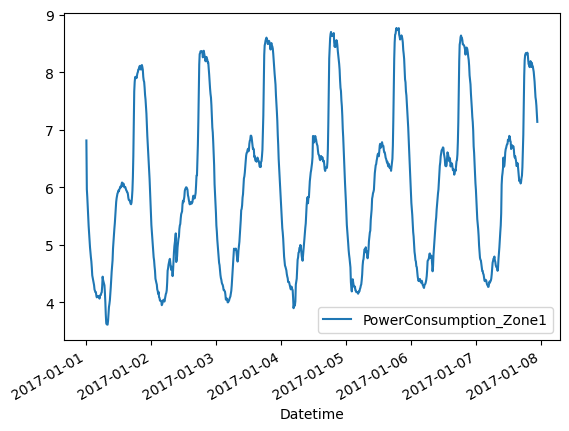

In [67]:
df_timewindow = df.iloc[:1000]
df_timewindow.plot(y='PowerConsumption_Zone1', x_compat=True)

___
## Dataset+Dataloader
___

In [68]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

batch_size = 1218 # little more than 1 week; minimize lost data in last batch

# shape (-1,num_features=3,1) : sequence runs across z-axis; listing features (e.g. zones) on y-axis
tensor_dataseq = torch.tensor(df.values, dtype=torch.float32)
num_features = df.shape[1]
tensor_dataseq = tensor_dataseq.reshape(-1, num_features, 1) 

# drop last datapoint since it has no successor
# concatenate datapoints and successors along x-axis
full_data = torch.cat((tensor_dataseq[:-1,:,:], tensor_dataseq[1:,:,:]), dim=2) 

# ratio of training and test data
# ensure last batch has full size
splitindex = int(.85 * len(df)/batch_size)
splitindex *= batch_size 

# dataset and dataloader
class Data(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

train_set = full_data[:splitindex, : , :]
test_set = full_data[splitindex:, : , :]

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

___
# LSTM Model
## Define Class
___
_Documentation:_ https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM


In [69]:
class LSTMen(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMen,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size,input_size)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out)
        return out

# choose which feature to extract for plot --> 2nd dim of prediction.shape
        feature = 0

___
## Train Model
___

In [70]:
import torch.optim as optim

num_epochs = 45
input_size = tensor_dataseq.shape[2] # input_size is number of values for each feature. here: 1
hidden_size = 50
num_layers = 3

model = LSTMen(input_size,hidden_size,num_layers)

learning_rate = .003 # do NOT use larger lr
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# initializing array to collect predictions from last epoch
predictions_flat = []

for epoch in range(num_epochs):  
    for index, batch in enumerate(train_loader): # 37 batches
        x_values = batch[:,:,[0]].requires_grad_() # measurements
        y_values = batch[:,:,[1]].requires_grad_() # true successors
        
        optimizer.zero_grad()
        prediction = model(x_values) 
        loss = criterion(prediction, y_values)
        loss.backward()
        
        optimizer.step()
    
        if (index+1) % 10 == 0:
            print(f"Epoch: {epoch:02} | Batch: {index+1:02} |  Loss: {loss.item():.4f}")
            
        if epoch == (num_epochs - 1):
            arrayBatchprediction_singleFeature = prediction[:,feature,:].detach().view(-1).numpy() 
            predictions_flat.extend(arrayBatchprediction_singleFeature)

Epoch: 00 | Batch: 10 |  Loss: 18.1615
Epoch: 00 | Batch: 20 |  Loss: 12.5156
Epoch: 00 | Batch: 30 |  Loss: 8.8294
Epoch: 01 | Batch: 10 |  Loss: 4.2346
Epoch: 01 | Batch: 20 |  Loss: 5.7866
Epoch: 01 | Batch: 30 |  Loss: 4.4820
Epoch: 02 | Batch: 10 |  Loss: 3.4437
Epoch: 02 | Batch: 20 |  Loss: 4.1183
Epoch: 02 | Batch: 30 |  Loss: 3.1664
Epoch: 03 | Batch: 10 |  Loss: 2.2130
Epoch: 03 | Batch: 20 |  Loss: 2.7553
Epoch: 03 | Batch: 30 |  Loss: 1.9911
Epoch: 04 | Batch: 10 |  Loss: 1.7216
Epoch: 04 | Batch: 20 |  Loss: 2.0975
Epoch: 04 | Batch: 30 |  Loss: 1.5142
Epoch: 05 | Batch: 10 |  Loss: 1.5223
Epoch: 05 | Batch: 20 |  Loss: 1.8737
Epoch: 05 | Batch: 30 |  Loss: 1.3208
Epoch: 06 | Batch: 10 |  Loss: 1.4376
Epoch: 06 | Batch: 20 |  Loss: 1.8036
Epoch: 06 | Batch: 30 |  Loss: 1.2439
Epoch: 07 | Batch: 10 |  Loss: 1.4131
Epoch: 07 | Batch: 20 |  Loss: 1.7797
Epoch: 07 | Batch: 30 |  Loss: 1.2110
Epoch: 08 | Batch: 10 |  Loss: 1.3995
Epoch: 08 | Batch: 20 |  Loss: 1.7797
Epoch: 08 

___
## Plot predictions compared to *training* data
___

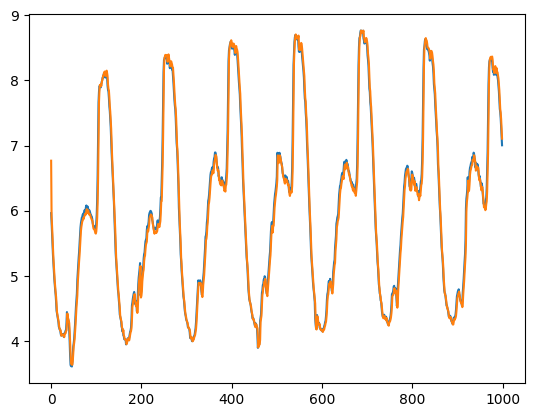

In [71]:
# 'feature' to plot defined at end of LSTM class cell
start = 0
end = start + 1000 # start and end of timeframe 
ideal_data_slice = tensor_dataseq[start+1:end+1,feature,:] # true successors
ideal_array = ideal_data_slice.squeeze().numpy()

prediction_array = predictions_flat[start:end]

plt.plot(ideal_array)
plt.plot(prediction_array)
plt.show()

___
## Plot predictions compared to *test* data
___

In [76]:
acc_predictions = [] # initialize array to accumulate predictions for test data

for index, batch in enumerate(test_loader):
    # drop last batch since it's too short
    if index + 1 == len(test_loader):
        break
    with torch.no_grad():
        x_values = batch[:,:,[0]]
        y_values = batch[:,:,[1]]#
        
        prediction = model(x_values)
        loss = criterion(prediction, y_values)

        print(f"Batch: {index+1:01} |  Loss: {loss.item():.4f}")

        arrayBatchprediction_singleFeature_test = prediction[:,feature,:].detach().view(-1).numpy() 
        acc_predictions.extend(arrayBatchprediction_singleFeature_test)

Batch: 1 |  Loss: 0.0578
Batch: 2 |  Loss: 0.0584
Batch: 3 |  Loss: 0.0525
Batch: 4 |  Loss: 0.0579
Batch: 5 |  Loss: 0.0641
Batch: 6 |  Loss: 0.0622
Batch: 7 |  Loss: 0.0613


In [77]:
len(tensor_dataseq)-splitindex

8568

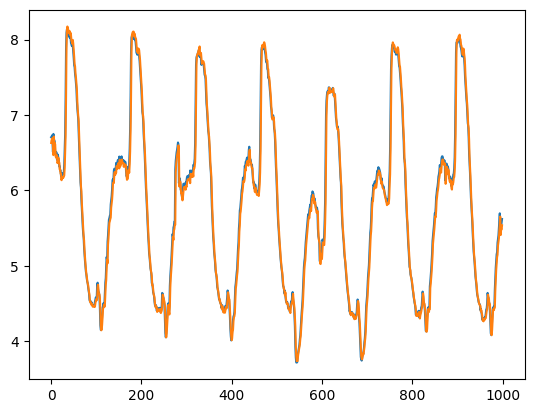

In [78]:
start = 0
end = start + 1000
ideal_data_slice = tensor_dataseq[splitindex+start+1:splitindex+end+1,feature,:] # shifted by splitindex(+1 for y-values)
ideal_array = ideal_data_slice.squeeze().numpy()

prediction_array = acc_predictions[start:end] # array STARTS at splitindex

plt.plot(ideal_array)
plt.plot(prediction_array)
plt.show()